<a href="https://colab.research.google.com/github/jhanvikh/jhanvi/blob/main/Hospital_Bed_Occupancy_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install mysql-connector-python pandas matplotlib scikit-learn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 34.8 MB/s eta 0:00:00


In [6]:
def connect_to_db():
    return mysql.connector.connect(
        host="your-public-mysql-host",  # e.g., AWS RDS endpoint or Google Cloud SQL IP
        user="your-username",
        password="your-password",
        database="hospital_db"
    )


In [8]:
def connect_to_db():
    return mysql.connector.connect(
        host="0.tcp.ngrok.io",
        port=12345,  # Replace with the port provided by Ngrok
        user="your-username",
        password="your-password",
        database="hospital_db"
    )


In [9]:
!apt-get install sqlite3


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
Suggested packages:
  sqlite3-doc
The following NEW packages will be installed:
  sqlite3
0 upgraded, 1 newly installed, 0 to remove and 49 not upgraded.
Need to get 768 kB of archives.
After this operation, 1,873 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 sqlite3 amd64 3.37.2-2ubuntu0.3 [768 kB]
Fetched 768 kB in 1s (709 kB/s)
Selecting previously unselected package sqlite3.
(Reading database ... 123630 files and directories currently installed.)
Preparing to unpack .../sqlite3_3.37.2-2ubuntu0.3_amd64.deb ...
Unpacking sqlite3 (3.37.2-2ubuntu0.3) ...
Setting up sqlite3 (3.37.2-2ubuntu0.3) ...
Processing triggers for man-db (2.10.2-1) ...


In [11]:
import sqlite3

# Connect to SQLite Database
conn = sqlite3.connect('hospital_bed_availability.db')
cursor = conn.cursor()

# Create Hospital_Wards table
cursor.execute("""
    CREATE TABLE IF NOT EXISTS Hospital_Wards (
        ward_id INTEGER PRIMARY KEY AUTOINCREMENT,
        ward_name TEXT NOT NULL,
        total_beds INTEGER NOT NULL,
        specialty TEXT
    );
""")

# Create Patients table
cursor.execute("""
    CREATE TABLE IF NOT EXISTS Patients (
        patient_id INTEGER PRIMARY KEY AUTOINCREMENT,
        patient_name TEXT NOT NULL,
        ward_id INTEGER,
        admission_date TEXT NOT NULL,
        discharge_date TEXT,
        FOREIGN KEY (ward_id) REFERENCES Hospital_Wards(ward_id)
    );
""")

# Create Bed_Occupancy table
cursor.execute("""
    CREATE TABLE IF NOT EXISTS Bed_Occupancy (
        occupancy_id INTEGER PRIMARY KEY AUTOINCREMENT,
        ward_id INTEGER,
        date TEXT NOT NULL,
        occupied_beds INTEGER NOT NULL,
        FOREIGN KEY (ward_id) REFERENCES Hospital_Wards(ward_id)
    );
""")

conn.commit()
conn.close()
print("Database and tables created successfully.")


Database and tables created successfully.


In [12]:
# Insert data into the database
def insert_dummy_data():
    conn = sqlite3.connect('hospital_bed_availability.db')
    cursor = conn.cursor()

    # Insert into Hospital_Wards
    cursor.executemany("""
        INSERT INTO Hospital_Wards (ward_name, total_beds, specialty) VALUES (?, ?, ?)
    """, [
        ('General Medicine', 50, 'Medicine'),
        ('ICU', 20, 'Critical Care'),
        ('Pediatrics', 30, 'Child Care'),
        ('Surgery', 40, 'Surgical Care')
    ])

    # Insert into Bed_Occupancy
    cursor.executemany("""
        INSERT INTO Bed_Occupancy (ward_id, date, occupied_beds) VALUES (?, ?, ?)
    """, [
        (1, '2024-11-20', 40),
        (2, '2024-11-20', 15),
        (3, '2024-11-20', 20),
        (4, '2024-11-20', 30),
        (1, '2024-11-21', 35),
        (2, '2024-11-21', 18)
    ])

    conn.commit()
    conn.close()
    print("Dummy data inserted successfully.")

insert_dummy_data()


Dummy data inserted successfully.


In [13]:
import pandas as pd

# Fetch occupancy data
def fetch_occupancy_data():
    conn = sqlite3.connect('hospital_bed_availability.db')
    query = """
    SELECT
        ward_name,
        date,
        occupied_beds,
        total_beds,
        (total_beds - occupied_beds) AS available_beds
    FROM
        Bed_Occupancy
    JOIN
        Hospital_Wards ON Bed_Occupancy.ward_id = Hospital_Wards.ward_id;
    """
    df = pd.read_sql_query(query, conn)
    conn.close()
    return df

occupancy_data = fetch_occupancy_data()
print(occupancy_data)


          ward_name        date  occupied_beds  total_beds  available_beds
0  General Medicine  2024-11-20             40          50              10
1               ICU  2024-11-20             15          20               5
2        Pediatrics  2024-11-20             20          30              10
3           Surgery  2024-11-20             30          40              10
4  General Medicine  2024-11-21             35          50              15
5               ICU  2024-11-21             18          20               2


In [14]:
from sklearn.linear_model import LinearRegression
import numpy as np

def predict_bed_occupancy(df, ward_name, days=7):
    df = df[df['ward_name'] == ward_name]
    df['date'] = pd.to_datetime(df['date'])
    df['day_number'] = (df['date'] - df['date'].min()).dt.days

    # Training Data
    X = df[['day_number']]
    y = df['occupied_beds']

    # Train Linear Regression Model
    model = LinearRegression()
    model.fit(X, y)

    # Predict for the next `days`
    future_days = np.arange(X['day_number'].max() + 1, X['day_number'].max() + 1 + days).reshape(-1, 1)
    predictions = model.predict(future_days)

    # Create future dates
    future_dates = [df['date'].max() + pd.Timedelta(days=i) for i in range(1, days + 1)]
    return pd.DataFrame({'date': future_dates, 'predicted_occupied_beds': predictions})

# Predict for General Medicine
predicted_occupancy = predict_bed_occupancy(occupancy_data, 'General Medicine')
print(predicted_occupancy)


        date  predicted_occupied_beds
0 2024-11-22             3.000000e+01
1 2024-11-23             2.500000e+01
2 2024-11-24             2.000000e+01
3 2024-11-25             1.500000e+01
4 2024-11-26             1.000000e+01
5 2024-11-27             5.000000e+00
6 2024-11-28             1.421085e-14


<ipython-input-14-1dbf08c7f196>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = pd.to_datetime(df['date'])
<ipython-input-14-1dbf08c7f196>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['day_number'] = (df['date'] - df['date'].min()).dt.days
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


<ipython-input-18-f711a489acf4>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = pd.to_datetime(df['date'])


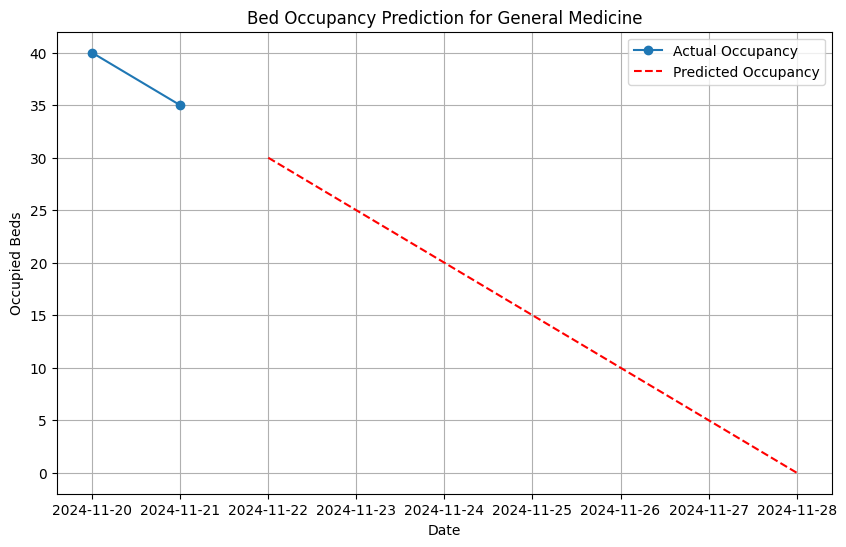

In [18]:
def plot_occupancy(df, predictions, ward_name):
    plt.figure(figsize=(10, 6))

    # Filter data for the specified ward
    df = df[df['ward_name'] == ward_name]

    # Ensure 'date' is in datetime format
    df['date'] = pd.to_datetime(df['date'])
    predictions['date'] = pd.to_datetime(predictions['date'])

    # Plot Actual Data
    plt.plot(df['date'], df['occupied_beds'], label="Actual Occupancy", marker='o')

    # Plot Predictions
    plt.plot(predictions['date'], predictions['predicted_occupied_beds'], label="Predicted Occupancy", linestyle='--', color='red')

    # Customize Plot
    plt.title(f"Bed Occupancy Prediction for {ward_name}")
    plt.xlabel("Date")
    plt.ylabel("Occupied Beds")
    plt.legend()
    plt.grid()
    plt.show()
plot_occupancy(occupancy_data, predicted_occupancy, 'General Medicine')



In [32]:
pip install prophet


In [33]:
from prophet import Prophet

def time_series_forecasting(df, ward_name):
    # Filter Data for the Selected Ward
    df = df[df['ward_name'] == ward_name][['date', 'occupied_beds']].rename(columns={"date": "ds", "occupied_beds": "y"})

    # Train Prophet Model
    model = Prophet()
    model.fit(df)

    # Forecast for the Next 7 Days
    future = model.make_future_dataframe(periods=7)
    forecast = model.predict(future)
    return forecast[['ds', 'yhat']]

# Example usage:
forecast = time_series_forecasting(occupancy_data, "General Medicine")
print(forecast)


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 0.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgcc6m86l/e_7nm4_j.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgcc6m86l/sryb83ao.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18076', 'data', 'file=/tmp/tmpgcc6m86l/e_7nm4_j.json', 'init=/tmp/tmpgcc6m86l/sryb83ao.json', 'output', 'file=/tmp/tmpgcc6m86l/prophet_modelud37phz5/prophet_model-20241125074519.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
07:45:19 - cmdstanpy - INFO - Chain [1] start processing
IN

          ds       yhat
0 2024-11-20  40.000000
1 2024-11-21  34.999982
2 2024-11-22  29.999964
3 2024-11-23  24.999945
4 2024-11-24  19.999927
5 2024-11-25  14.999909
6 2024-11-26   9.999891
7 2024-11-27   4.999873
8 2024-11-28  -0.000146


In [35]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import xgboost as xgb
import numpy as np

# Assuming your dataset is loaded into 'occupancy_data'
# Make sure 'date' column is in datetime format
occupancy_data['date'] = pd.to_datetime(occupancy_data['date'])

# Create the 'day_number' column based on the date
min_date = occupancy_data['date'].min()
occupancy_data['day_number'] = (occupancy_data['date'] - min_date).dt.days

# Model evaluation function
def evaluate_models(df, target_column='occupied_beds', features_columns=['day_number']):
    X = df[features_columns]
    y = df[target_column]

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    models = {
        "Linear Regression": LinearRegression(),
        "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
        "XGBoost": xgb.XGBRegressor(objective="reg:squarederror", random_state=42)
    }

    results = {}

    # Train and evaluate each model
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        # Calculate evaluation metrics
        mae = mean_absolute_error(y_test, y_pred)
        rmse = mean_squared_error(y_test, y_pred, squared=False)
        r2 = r2_score(y_test, y_pred)

        # Store results
        results[name] = {
            "MAE": mae,
            "RMSE": rmse,
            "R²": r2
        }

    # Print out results for each model
    for model_name, metrics in results.items():
        print(f"Model: {model_name}")
        print(f"  MAE: {metrics['MAE']:.2f}")
        print(f"  RMSE: {metrics['RMSE']:.2f}")
        print(f"  R²: {metrics['R²']:.2f}\n")

    return results

# Example usage
results = evaluate_models(occupancy_data, target_column='occupied_beds', features_columns=['day_number'])


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Model: Linear Regression
  MAE: 12.50
  RMSE: 12.75
  R²: -0.04

Model: Random Forest
  MAE: 12.50
  RMSE: 12.68
  R²: -0.03

Model: XGBoost
  MAE: 12.50
  RMSE: 12.75
  R²: -0.04



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [36]:
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score

def evaluate_models(df, target_column='occupied_beds', features_columns=['day_number']):
    X = df[features_columns]
    y = df[target_column]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    models = {
        "Linear Regression": LinearRegression(),
        "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
        "XGBoost": xgb.XGBRegressor(objective="reg:squarederror", random_state=42)
    }

    results = {}

    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        mae = mean_absolute_error(y_test, y_pred)
        rmse = root_mean_squared_error(y_test, y_pred)  # Updated to use root_mean_squared_error
        r2 = r2_score(y_test, y_pred)

        results[name] = {
            "MAE": mae,
            "RMSE": rmse,
            "R²": r2
        }

    # Print out results for each model
    for model_name, metrics in results.items():
        print(f"Model: {model_name}")
        print(f"  MAE: {metrics['MAE']:.2f}")
        print(f"  RMSE: {metrics['RMSE']:.2f}")
        print(f"  R²: {metrics['R²']:.2f}\n")

    return results

# Example usage
results = evaluate_models(occupancy_data, target_column='occupied_beds', features_columns=['day_number'])


Model: Linear Regression
  MAE: 12.50
  RMSE: 12.75
  R²: -0.04

Model: Random Forest
  MAE: 12.50
  RMSE: 12.68
  R²: -0.03

Model: XGBoost
  MAE: 12.50
  RMSE: 12.75
  R²: -0.04

